# NeurIPS_Open-Polymer-Prediction-2025

### Goal 
Predicting polymer properties with machine learning to accelerate sustainable materials research.

### Data
In this competition, your task is to use polymer structure data (SMILES) to predict five key chemical properties derived from molecular dynamics simulation: glass transition temperature (Tg), fractional free volume (FFV), thermal conductivity (Tc), polymer density, and radius of gyration (Rg). Successfully predicting these properties is crucial for scientists to accelerate the design of novel polymers with targeted characteristics, which can be used in various applications.

In [1]:
#import
import numpy as np
import pandas as pd
from rdkit import Chem
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem, DataStructs
from sklearn.manifold import TSNE
from rdkit.Chem import Descriptors, rdMolDescriptors

In [2]:
datafile = pd.read_csv("train.csv")

In [3]:
datafile

,id,SMILES,Tg,FFV,Tc,Density,Rg
0,87817,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN
1,106919,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN
2,388772,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN
3,519416,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN
4,539187,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN
...,...,...,...,...,...,...,...
7968,2146592435,*Oc1cc(CCCCCCCC)cc(OC(=O)c2cccc(C(*)=O)c2)c1,NaN,0.367498,NaN,NaN,NaN
7969,2146810552,*C(=O)OCCN(CCOC(=O)c1ccc2c(c1)C(=O)N(c1cccc(N3...,NaN,0.353280,NaN,NaN,NaN
7970,2147191531,*c1cc(C(=O)NCCCCCCCC)cc(N2C(=O)c3ccc(-c4ccc5c(...,NaN,0.369411,NaN,NaN,NaN
7971,2147435020,*C=C(*)c1ccccc1C,261.662355,NaN,NaN,NaN,NaN


In [12]:
datafile.drop_duplicates().shape #no duplicate

(7973, 7)

In [13]:
datafile.isna().sum()

id            0
SMILES        0
Tg         7462
FFV         943
Tc         7236
Density    7360
Rg         7359
dtype: int64

#### EDA

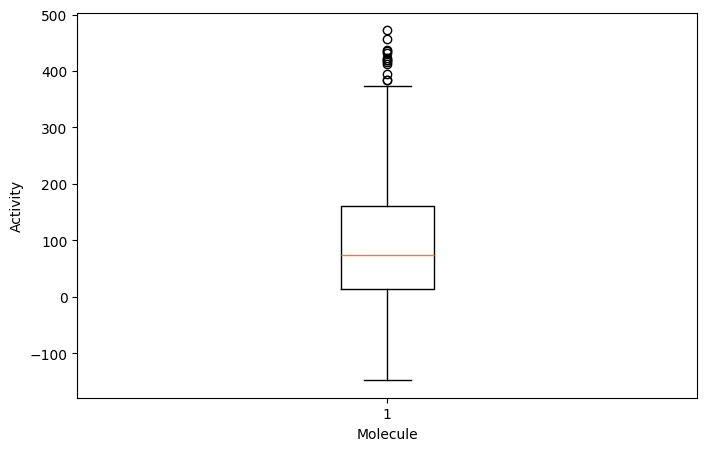

In [17]:
plt.figure(figsize=(8, 5))
plt.boxplot(datafile["Tg"].dropna())
plt.xlabel("Molecule")
plt.ylabel("Activity")
plt.show()

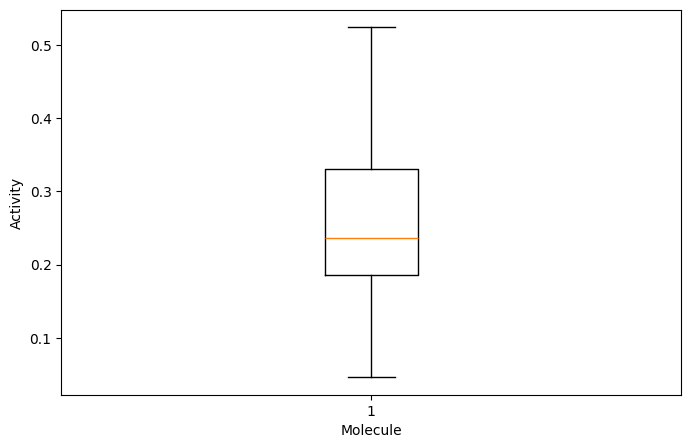

In [19]:
plt.figure(figsize=(8, 5))
plt.boxplot(datafile["Tc"].dropna())
plt.xlabel("Molecule")
plt.ylabel("Activity")
plt.show()

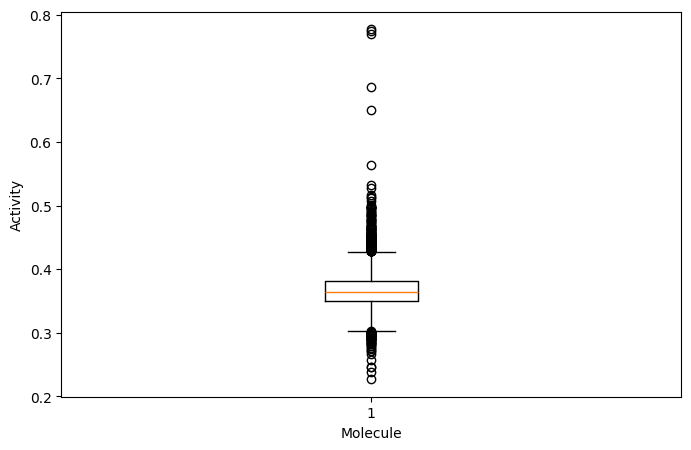

In [20]:
plt.figure(figsize=(8, 5))
plt.boxplot(datafile["FFV"].dropna())
plt.xlabel("Molecule")
plt.ylabel("Activity")
plt.show()

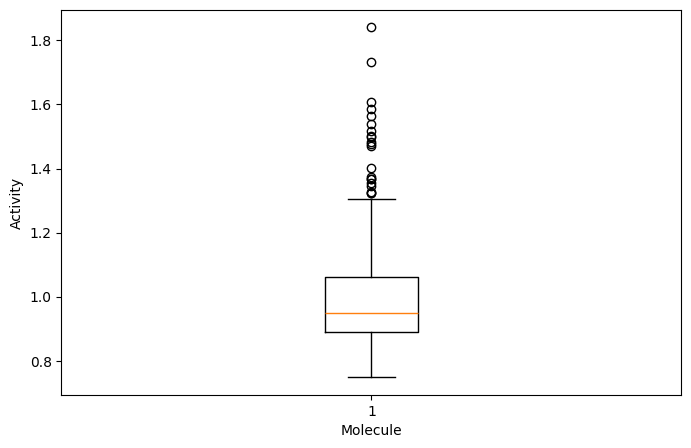

In [22]:
plt.figure(figsize=(8, 5))
plt.boxplot(datafile["Density"].dropna())
plt.xlabel("Molecule")
plt.ylabel("Activity")
plt.show()

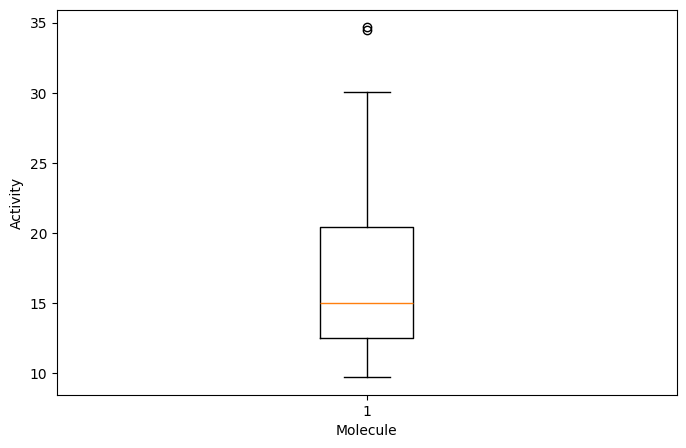

In [23]:
plt.figure(figsize=(8, 5))
plt.boxplot(datafile["Rg"].dropna())
plt.xlabel("Molecule")
plt.ylabel("Activity")
plt.show()

In [25]:
data=datafile.copy()

In [24]:
#Number of atoms
def get_num_nodes(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol.GetNumAtoms() if mol else 0

In [28]:
#Rg
datafile = data[['SMILES','Rg']]
datafile.dropna(inplace=True)

C:\Users\shasa\AppData\Local\Temp\ipykernel_32128\2487293359.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafile.dropna(inplace=True)


In [29]:
smiles_list = datafile["SMILES"].to_list()
activity_values = datafile["Rg"].to_list()

In [30]:
datafile["atoms"] = [get_num_nodes(s) for s in smiles_list]

C:\Users\shasa\AppData\Local\Temp\ipykernel_32128\802071510.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafile["atoms"] = [get_num_nodes(s) for s in smiles_list]


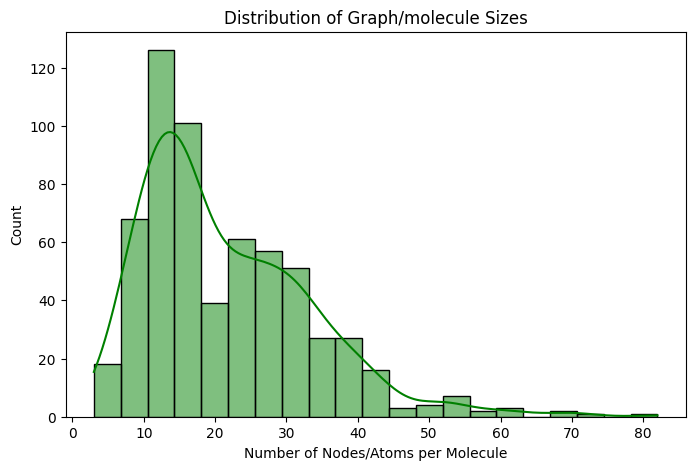

In [31]:
plt.figure(figsize=(8, 5))
sns.histplot(datafile["atoms"],  kde=True, color='g')
plt.xlabel("Number of Nodes/Atoms per Molecule")
plt.ylabel("Count")
plt.title("Distribution of Graph/molecule Sizes")
plt.show()

In [210]:
#datafile = datafile[datafile["atoms"]<=40]

In [32]:
size = datafile["atoms"].to_list()

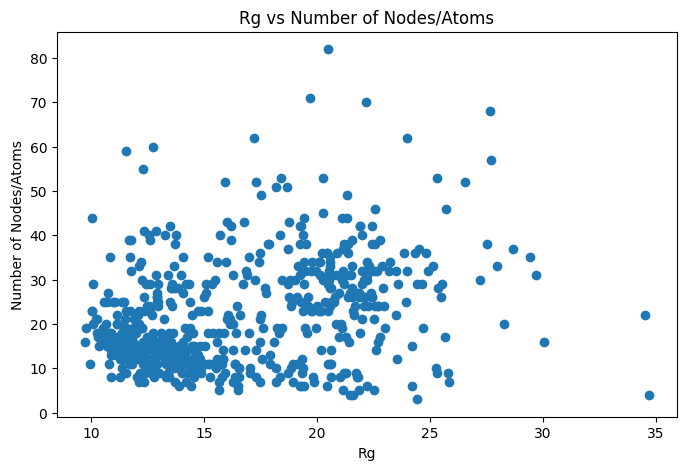

In [34]:
plt.figure(figsize=(8, 5))
plt.scatter(datafile.Rg,datafile.atoms)
plt.xlabel("Rg")
plt.ylabel("Number of Nodes/Atoms")
plt.title("Rg vs Number of Nodes/Atoms")
plt.show()

#### Chemical space

In [35]:
#Generating Morgan Fingerprint
def smiles_to_fingerprint(smiles, radius=3, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [36]:
fingerprints = np.array([smiles_to_fingerprint(s) for s in smiles_list if smiles_to_fingerprint(s) is not None])

[22:55:57] DEPRECATION WARNING: please use MorganGenerator
[22:55:57] DEPRECATION WARNING: please use MorganGenerator
[22:55:57] DEPRECATION WARNING: please use MorganGenerator
[22:55:57] DEPRECATION WARNING: please use MorganGenerator
[22:55:57] DEPRECATION WARNING: please use MorganGenerator
[22:55:57] DEPRECATION WARNING: please use MorganGenerator
[22:55:57] DEPRECATION WARNING: please use MorganGenerator
[22:55:57] DEPRECATION WARNING: please use MorganGenerator
[22:55:57] DEPRECATION WARNING: please use MorganGenerator
[22:55:57] DEPRECATION WARNING: please use MorganGenerator
[22:55:57] DEPRECATION WARNING: please use MorganGenerator
[22:55:57] DEPRECATION WARNING: please use MorganGenerator
[22:55:57] DEPRECATION WARNING: please use MorganGenerator
[22:55:57] DEPRECATION WARNING: please use MorganGenerator
[22:55:57] DEPRECATION WARNING: please use MorganGenerator
[22:55:57] DEPRECATION WARNING: please use MorganGenerator
[22:55:57] DEPRECATION WARNING: please use MorganGenerat

In [40]:
#tSNE

In [37]:
tsne = TSNE(n_components=2, random_state=42, perplexity=50) #https://scikit-learn.org/stable/auto_examples/manifold/plot_t_sne_perplexity.html
embedding = tsne.fit_transform(fingerprints)

In [38]:
df = pd.DataFrame(embedding, columns=["X", "Y"])
df["Rg"] = activity_values[:len(df)]
df["size"] = size[:len(df)]

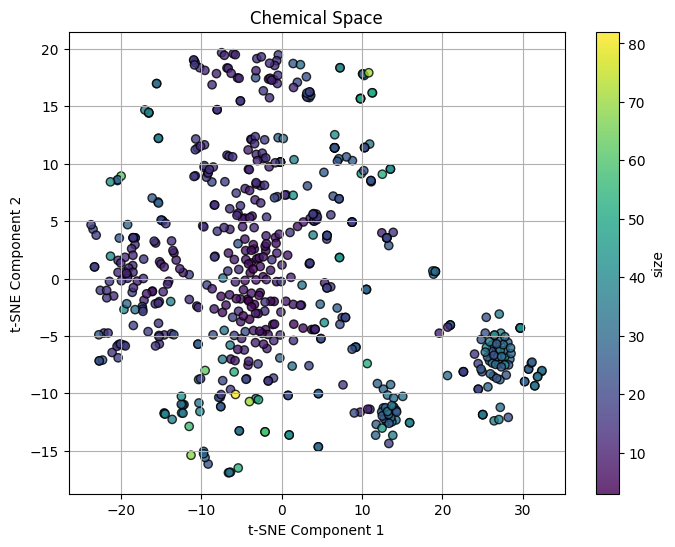

In [39]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df["X"], df["Y"], c=df["size"], cmap="viridis", edgecolors='k', alpha=0.8)
plt.colorbar(scatter, label="size")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Chemical Space")
plt.grid(True)
plt.show()

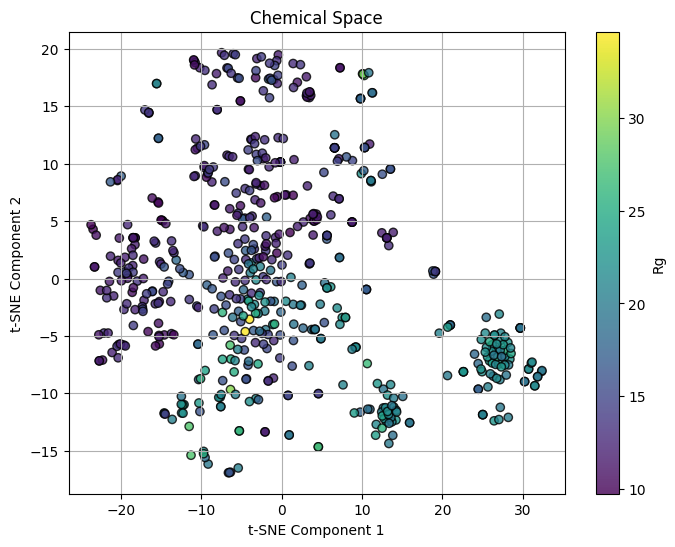

In [40]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df["X"], df["Y"], c=df["Rg"], cmap="viridis", edgecolors='k', alpha=0.8)
plt.colorbar(scatter, label="Rg")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Chemical Space")
plt.grid(True)
plt.show()

In [133]:
#adding more properties

In [41]:
def feature(smiles):
    mol = Chem.MolFromSmiles(smiles)
    logp = Descriptors.MolLogP(mol)  
    tpsa = Descriptors.TPSA(mol)
    hbd = Descriptors.NumHDonors(mol)  #Hydrogen Bond Donors
    hba = Descriptors.NumHAcceptors(mol)  #Hydrogen Bond Acceptors
    rotatable_bonds = Descriptors.NumRotatableBonds(mol) 
    f_sp3 = rdMolDescriptors.CalcFractionCSP3(mol)  #Fraction sp3 Carbon
    num_rings = rdMolDescriptors.CalcNumRings(mol) 
    aromatic_rings = rdMolDescriptors.CalcNumAromaticRings(mol)
    formal_charge = Chem.GetFormalCharge(mol)
    return [smiles,logp,tpsa,hbd,hba,rotatable_bonds,f_sp3,num_rings,aromatic_rings,formal_charge]

In [42]:
list_dict=[]
for i in datafile["SMILES"]:
    list_dict.append(feature(i))

In [43]:
prop = pd.DataFrame(list_dict)

In [44]:
prop.columns = ["SMILES","logp","tpsa","hbd","hba","rotatable_bonds","f_sp3","num_rings","aromatic_rings","formal_charge"]

In [45]:
data_prop = datafile.merge(prop,on="SMILES").drop_duplicates()

In [139]:
#are the properties correlated with activity!

In [48]:
data_prop = data_prop[["logp","tpsa","hbd","hba","rotatable_bonds","f_sp3","num_rings","aromatic_rings","formal_charge","Rg"]]

In [49]:
data_prop.corr()["Rg"]

logp               0.256600
tpsa               0.264673
hbd                0.330302
hba                0.167181
rotatable_bonds    0.344738
f_sp3             -0.063880
num_rings          0.143468
aromatic_rings     0.182404
formal_charge      0.033727
Rg                 1.000000
Name: Rg, dtype: float64

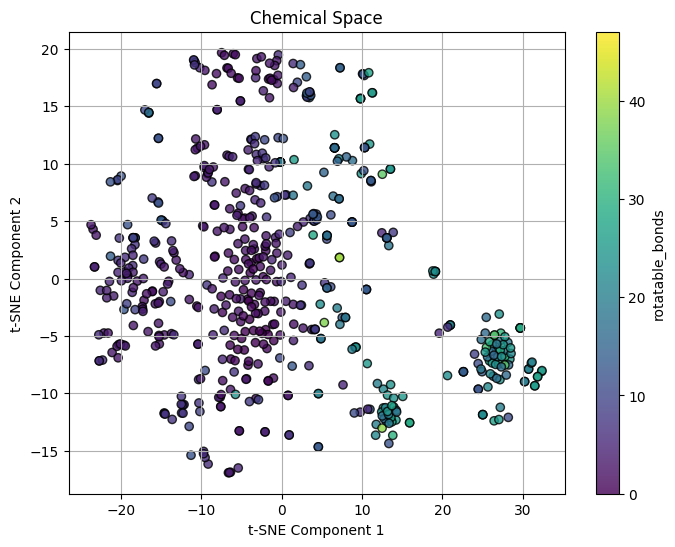

In [50]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df["X"], df["Y"], c=data_prop["rotatable_bonds"], cmap="viridis", edgecolors='k', alpha=0.8)
plt.colorbar(scatter, label="rotatable_bonds")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Chemical Space")
plt.grid(True)
plt.show()

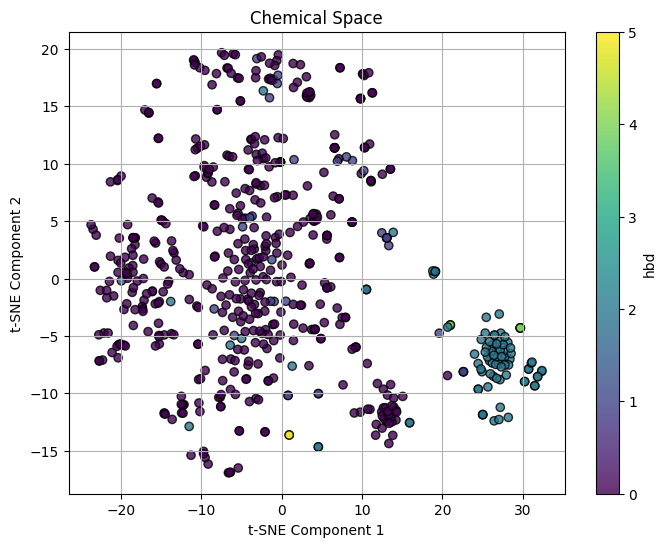

In [51]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df["X"], df["Y"], c=data_prop["hbd"], cmap="viridis", edgecolors='k', alpha=0.8)
plt.colorbar(scatter, label="hbd")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Chemical Space")
plt.grid(True)
plt.show()